## Language Processing 2

### Session 11

#### Jurgen Wedekind & Manex Agirrezabal

Good sources of information:

 - https://dynet.readthedocs.io/en/latest/python_ref.html
 - https://dynet.readthedocs.io/en/latest/tutorials_notebooks/RNNs.html
 
 - http://phontron.com/slides/emnlp2016-dynet-tutorial-part1.pdf
 - http://phontron.com/slides/emnlp2016-dynet-tutorial-part2.pdf
 
 - https://github.com/clab/dynet/

In [1]:
import dynet as dy

```
conda create -n superdynet python=3.6 anaconda
conda activate superdynet
pip install dynet

```

### The goal

  - Intro to DyNet
  - Gradient Descent (exercise with NLP)
  - Recurrent Neural Networks with DyNet

### Intro to DyNet



 - Computation Graph
 - Expressions (~nodes in the graph)
 - Parameters
 - Model - a collection of parameters (`ParameterCollection`)
 - Trainer


### Computation graphs

 - Deep Learning’s Lingua Franca
 - Page 13: http://phontron.com/slides/emnlp2016-dynet-tutorial-part1.pdf

### Expressions

Expressions are the main data types being manipulated in a DyNet program. Each expression represents a sub-computation in a computation graph.

### Parameters

Parameters are things that are optimized.

#### Lookup parameters

LookupParameters represents a table of parameters.

They are used to embed a set of discrete objects (e.g. word embeddings).

### Model or `ParameterCollection`

A colllection of parameters.

### Trainer

This is the one that will update the weights.

 - Initialize a Trainer with a given model.
 - Compute gradients by calling `expr.backward()` from a scalar node.
 - Call `trainer.update()` to update the model parameters using the gradients.

## Training with DyNet (today)

 - Create model, add parameters, create trainer.
 - For each training example:
    - create computation graph for the loss
    - run forward (compute the loss)
    - run backward (compute the gradients)
    - update parameters

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def linearly_seperable_data(num_instances, epsilon=0.1):
    '''
    generates a linearly separable data set
    '''
    # fill the first column (the labels) randomly with -1s and 1s
    labels = 2 * np.random.randint(0, 2, num_instances) - 1
    # pick x1 at random
    x1 = np.random.random(num_instances)
    # base x2 off of x1, add random noise and epsilon, and move up or down
    x2 = x1 + ((epsilon + np.random.random(num_instances)) * labels)
    labels = ((labels+1)/2).astype(int)
    return pd.DataFrame({'x1': x1, 'x2': x2, 'label': labels})

In [4]:
np.random.seed(24)
l_s_d = linearly_seperable_data(100)
l_s_d.head()

,x1,x2,label
0,0.916664,0.067679,0
1,0.002023,0.941277,1
2,0.971332,0.825757,0
3,0.889048,1.494691,1
4,0.699489,1.388303,1


In [5]:
X = l_s_d[['x1','x2']].values
y = l_s_d['label']
X.shape,y.shape

((100, 2), (100,))

In [6]:
#MODEL SPECIFICATION
model = dy.ParameterCollection()
W_p = model.add_parameters((2, 2))
b_p = model.add_parameters (2)

trainer = dy.SimpleSGDTrainer (model)

num_epochs = 100
closses = []


for epoch in range(num_epochs):
    closs = 0

    for input_x, out_label in zip(X,y):
        dy.renew_cg()
        x = dy.inputVector(input_x) #This must go after renewing the graph
        
        output_value = dy.logistic(W_p*x+b_p)
        
        loss = dy.hinge(output_value,out_label)

        loss_val = loss.value()
        closs = closs + loss_val
        
        loss.backward ()
        trainer.update()
    
    print (closs/len(l_s_d))
    closses.append(closs/len(l_s_d))

0.640983813405037
0.5310313957929611
0.4631859940290451
0.41374624490737916
0.3766621547937393
0.3481876826286316
0.3257425856590271
0.30759513318538667
0.2925882142782211
0.27993600726127627
0.269091460108757
0.25966390073299406
0.2513677132129669
0.24398960888385773
0.23736720263957978
0.2313747549057007
0.2259134656190872
0.22090457916259765
0.21628454566001892
0.2120015001296997
0.2080126655101776
0.20428249180316926
0.20078113913536072
0.19748337626457213
0.19436767160892487
0.19141557812690735
0.18861126720905305
0.18594085693359375
0.18339235246181487
0.18095520675182342
0.1786201375722885
0.17637895286083222
0.17422431349754333
0.17214976966381074
0.17014945447444915
0.16821819841861724
0.1663512843847275
0.16454450011253358
0.16279396891593934
0.16109627544879912
0.15944820404052734
0.1578469008207321
0.15628962457180023
0.15477409243583679
0.15329797327518463
0.15185929834842682
0.15045614063739776
0.14908674359321594
0.14774954438209534
0.14644303381443025
0.1451658415794372

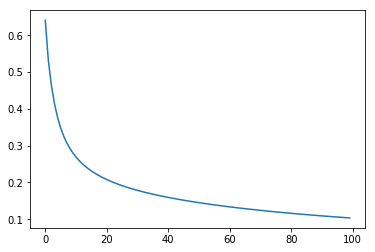

In [11]:
plt.plot(closses);

### Questions:

  - Why is the gradient going always down?
  - How to check when to stop the learning process?

### Gradient descent in NLP

The goal is to train a model that will distinguish Spanish and English names (feel free to do it with other languages).

I'll use the data from [this website](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html).

In [8]:
!head ./names/English.txt

head: cannot open './names/English.txt' for reading: No such file or directory


In [9]:
!head ./names/Spanish.txt

head: cannot open './names/Spanish.txt' for reading: No such file or directory


In [10]:
f=open(".//names/English.txt")
names_english=[line.strip().lower() for line in f]
f.close()
f=open("./names/Spanish.txt")
names_spanish=[line.strip().lower() for line in f]
f.close()
len(names_english),names_english[:5],len(names_spanish),names_spanish[:5]

FileNotFoundError: [Errno 2] No such file or directory: './/names/English.txt'

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

### Exercise

#### Represent these names as Bag of Character bigrams

#### and English/Spanish as classes 0 and 1

#### save them in variables `X_train` and `y_train`

#### and use the following code to find good parameters

##### Hint: `CountVectorizer`

In [ ]:
#YOUR CODE HERE

In [ ]:
#MODEL SPECIFICATION
model = dy.ParameterCollection()

W_p = model.add_parameters((2, 536))
b_p = model.add_parameters (2)
trainer = dy.SimpleSGDTrainer (model)

num_epochs = 100
closses = []

for epoch in range(num_epochs):
    closs = 0

    for input_x, out_label in zip(X_train,y_train):
        dy.renew_cg()
        x = dy.inputVector(input_x.toarray().reshape(-1)) #This must go after renewing the graph
        
        output_value = dy.logistic(W_p*x+b_p)
        
        loss = dy.hinge(output_value,out_label)

        loss_val = loss.value()
        closs = closs + loss_val
        
        loss.backward ()
        trainer.update()
    
    print (closs/len(y_train))
    closses.append(closs/len(y_train))
    


In [ ]:
plt.plot(closses)

## Intuition about verbs in Spanish (blackboard)

  - tocar $\rightarrow$ ?
  - Extra raw text
  - Other possible usages of raw text
    - POS tagging + extra character information (`frontofning`)

In [ ]:
!cp ../experiments/util.py ./
!cp ../experiments/allnames.txt ./


In [ ]:
import util
from itertools import count
import random
import time
from collections import defaultdict

In [ ]:
class RNNLanguageModel:
    def __init__(self, model, LAYERS, INPUT_DIM, HIDDEN_DIM, VOCAB_SIZE, builder=dy.SimpleRNNBuilder):
        self.builder = builder(LAYERS, INPUT_DIM, HIDDEN_DIM, model)

        self.lookup = model.add_lookup_parameters((VOCAB_SIZE, INPUT_DIM), name="lookup")
        self.R = model.add_parameters((VOCAB_SIZE, HIDDEN_DIM), name="hidden2out")
        self.bias = model.add_parameters((VOCAB_SIZE), name="bias")

    def save_to_disk(self, filename):
        dy.save(filename, [self.builder, self.lookup, self.R, self.bias])

    def load_from_disk(self, filename):
        (self.builder, self.lookup, self.R, self.bias) = dy.load(filename, model)
        
    def build_lm_graph(self, sent):
        dy.renew_cg()
        init_state = self.builder.initial_state()

        errs = [] # will hold expressions
        es=[]
        state = init_state
        for (cw,nw) in zip(sent,sent[1:]):
            # assume word is already a word-id
            x_t = dy.lookup(self.lookup, int(cw))
            state = state.add_input(x_t)
            y_t = state.output()
            r_t = self.bias + (self.R * y_t)
            err = dy.pickneglogsoftmax(r_t, int(nw))
            errs.append(err)
        nerr = dy.esum(errs)
        return nerr
    
    def predict_next_word(self, sentence):
        dy.renew_cg()
        init_state = self.builder.initial_state()
        state = init_state
        for cw in sentence:
            # assume word is already a word-id
            x_t = self.lookup[int(cw)]
            state = state.add_input(x_t)
        y_t = state.output()
        r_t = self.bias + (self.R * y_t)
        prob = dy.softmax(r_t)
        return prob
        
    def sample(self, first=1, nchars=0, stop=-1):
        res = [first]
        dy.renew_cg()
        state = self.builder.initial_state()

        cw = first
        while True:
            x_t = self.lookup[cw]
            state = state.add_input(x_t)
            y_t = state.output()
            r_t = self.bias + (self.R * y_t)
            ydist = dy.softmax(r_t)
            dist = ydist.vec_value()
            rnd = random.random()
            for i,p in enumerate(dist):
                rnd -= p
                if rnd <= 0: break
            res.append(i)
            cw = i
            if cw == stop: break
            if nchars and len(res) > nchars: break
        return res

In [ ]:
help(util.CharsCorpusReader)

In [ ]:
corpus = "allnames.txt"

LAYERS = 2
INPUT_DIM = 32 #50  #256
HIDDEN_DIM = 128 # 50  #1024

train = util.CharsCorpusReader(corpus, begin="<s>")
vocab = util.Vocab.from_corpus(train)

VOCAB_SIZE = vocab.size()

model = dy.Model()

trainer = dy.SimpleSGDTrainer(model, learning_rate=0.2)

lm = RNNLanguageModel(model, LAYERS, INPUT_DIM, HIDDEN_DIM, VOCAB_SIZE, builder=dy.SimpleRNNBuilder)
#lm = RNNLanguageModel(model, LAYERS, INPUT_DIM, HIDDEN_DIM, VOCAB_SIZE, builder=dy.LSTMBuilder)


train = list(train)

losses = []

chars = loss = 0.0
for ITER in range(3):
    random.shuffle(train)
    for i,sent in enumerate(train):
        _start = time.time()
        if i % 2500 == 0:
            trainer.status()
            print (i,len(train))
            if chars > 0: print(loss / chars,)
            for _ in range(1):
                samp = lm.sample(first=vocab.w2i["<s>"],stop=vocab.w2i["\n"])
                print("".join([vocab.i2w[c] for c in samp]).strip())
            loss = 0.0
            chars = 0.0

        chars += len(sent)-1
        isent = [vocab.w2i[w] for w in sent]
        errs = lm.build_lm_graph(isent)
        loss += errs.scalar_value()
        errs.backward()
        trainer.update()
    print ("TM:",(time.time() - _start)/len(sent))
    print("ITER {}, loss={}".format(ITER, loss))
    losses.append(loss)
    trainer.status()

lm.save_to_disk("RNNLanguageModel.model")

print("loading the saved model...")
lm.load_from_disk("RNNLanguageModel.model")
samp = lm.sample(first=vocab.w2i["<s>"],stop=vocab.w2i["\n"])
print("".join([vocab.i2w[c] for c in samp]).strip())


#### Question:

  - How would you get the character-based representation of a word, such as, `Peter` or `animalkind`?